## Brief Introduction
In this notebook, I experimennt the visualization of Ranking Metrics for the Anomaly Detection Model after PCA. The problem is set up as "Unsupervised Anomaly Detection". I split the dataset into the Validation and Testing Dataset. 

The anomaly in the datast is a figure with mustache.

Data Source: http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from PIL import Image
from scipy.io import loadmat  
from scipy import stats  
from scipy.stats import multivariate_normal
import re
import glob
from operator import itemgetter 
import random
from random import shuffle
from processing_functions import * # local to this notebook

import os
os.chdir('../')

from support_functions import *
from PCA_Functions import *

Using TensorFlow backend.


## Parameters

In [2]:
# Define the number of Principal Components to keep from the image
n_components  = 50

## Import Dataset

In [3]:
# Define the images to be read and the corresponding labels
label_1_folder = [9,21]
target_folders = range(1,22)
data_path = "Yale_Faces_Data/CroppedYale/"

# We also need to reduce the size of the image for the convenience of computation
reduce_height = 24
reduce_width = 21

# Read the images and reduce the size
images,labels = read_images(data_path,target_folders,label_1_folder,reduce_height,reduce_width)

# To evaluate the threshold of the dark pixels
# dark_pixel_curve(images)

imgs = images[:] # Create a copy
# Eliminate the images and labels whose number of dark pixels are above the threshold
# The threshold is determined based on the dark_pixel_curve() function above
imgs,labels,remove_count = remove_dark_img(imgs,labels,180) 

574  images are above our threshold and thus removed from the list


## Apply PCA on the Normal Images for Dimension Reduction

#### Define the number of components to be remained in the PCA Matrix

In [4]:
n_components = 20

#### Pre-processing

In [5]:
# Find the dimension of one image
height, width = imgs[0].shape
num_imgs = len(imgs)

# reshape to a 2-D Matrix
imgs_matrix = np.zeros((num_imgs,height*width)) # Initialize the matrix to store the entire image list
# Iterate through each image, convert it into an array, and add to the imgs_matrix as a new row
for i in range(0,len(imgs)):
    imgs_matrix[i,:] = imgs[i].reshape(height*width)

# Vectorize the labels list
labels_vector = np.hstack(labels) # Easier to get multiple items from a vector than from a list

#### Reconstruct the images with PCA
- Compute PCA on only the normal
- Plot eigenfaces
- Encode and Decode the images with PCA
- Plot the comparison between the original and reconstructed images

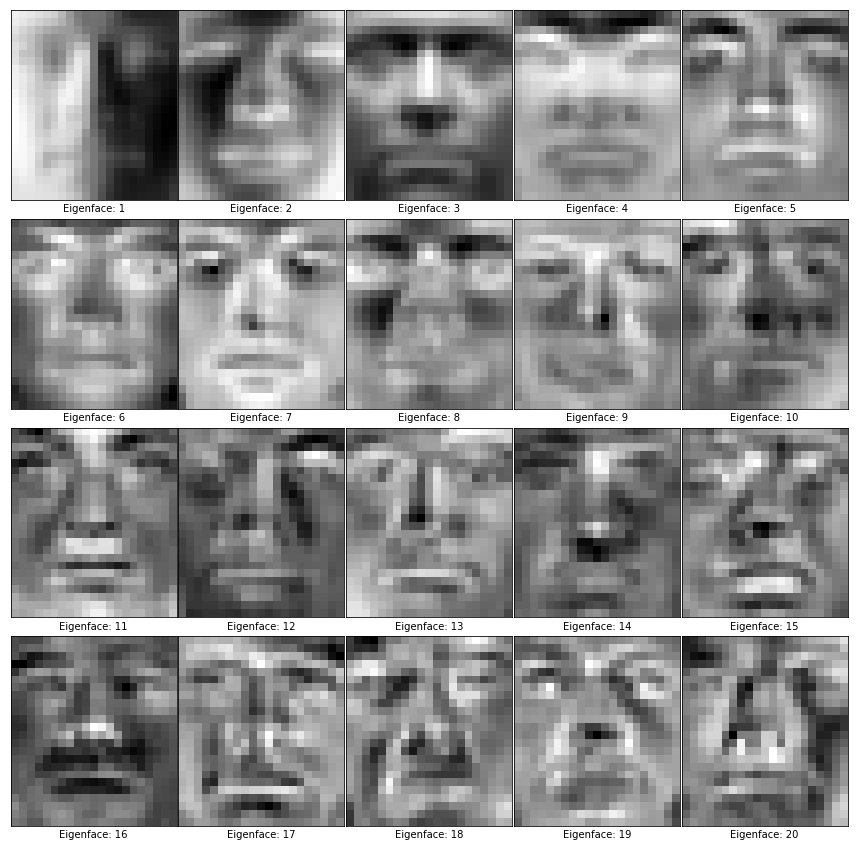

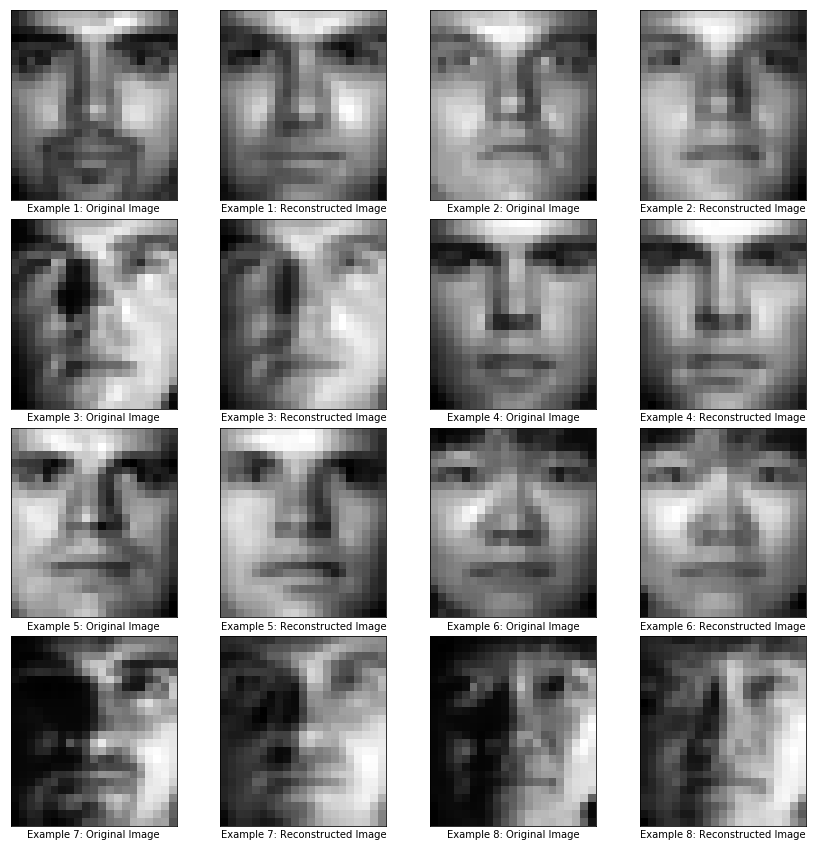

In [6]:
imgs_reconstructed,pca_matrix, component_mean = pca_all_processes(imgs_matrix,labels_vector,n_components,plot_eigenfaces_bool = True,plot_comparison_bool = True,height=height,width=width)

## Anomaly Detection with Reconstruction Error

### Split the Data into the Validation and Test Set
With the function, we get the indice of images to be assigned to the Training and Validation set

In [7]:
# Split the images and labels
ratio_train = 0.7 # No training set
train_ind, test_ind = split_training(labels_vector,ratio_train)

img_train = imgs_matrix[train_ind,:] # Original Image Set
img_train_pca = imgs_reconstructed[train_ind,:] # Reconstructed Image Set

img_test = imgs_matrix[test_ind,:] # Original Image Set
img_test_pca = imgs_reconstructed[test_ind,:] # Reconstructed Image Set

labels_train = labels_vector[train_ind]
labels_test = labels_vector[test_ind]

### Find the Optimal Threshold based on the Training dataset

The higher the reconstruction error, the more likely the point will be an anomaly


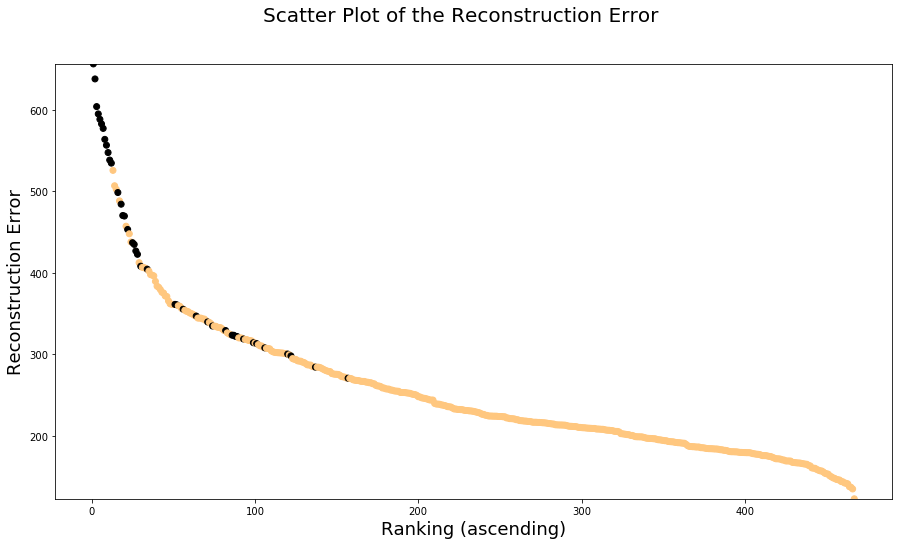

In [8]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist_train = find_euclidean_distance(img_train_pca,img_train)
print("The higher the reconstruction error, the more likely the point will be an anomaly")
plot_scatter_with_labels(dist_train,labels_train,"Reconstruction Error")

In [9]:
k = 20 # Define the k parameter for the precision at k
threshold_error = select_threshold_distance(dist_train, labels_train,k,to_print = True)

Precision: 73.3%
Recall: 52.4%
F-score: 61.1%
Precision@20: 80.0%


### Evaluate the Detector with the Testing Dataset

In [10]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist_test = find_euclidean_distance(img_test_pca,img_test)

# Sort the Images and Labels based on the Probability
rank_test = np.argsort(-dist_test) # Sort from the Largest to the Smallest
dist_test_ranked = dist_test[rank_test] # Sort the distance
# Rank Labels
labels_test_ranked = labels_test[rank_test]
# Give Predictions
preds = np.zeros(labels_test.shape) # Initialization
preds[dist_test_ranked > threshold_error] = 1

# Evaluate the Detector with Testing Data
eval_with_test(preds, labels_test_ranked, k = 10)

Precision: 90.0%
Recall: 40.9%
F-score: 56.3%
Precision@10: 90.0%
